In [103]:
import binance
import json
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense


from sklearn.preprocessing import MinMaxScaler

In [104]:
client = binance.Client()

res = client.get_klines(symbol='BTCUSDT', interval=client.KLINE_INTERVAL_5MINUTE, limit=1000)

def filter(item: list):
  return item[0:6]

data = list(map(filter, res))
df = pd.DataFrame(data, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])

df['Open'] = df['Open'].astype('float64')
df['High'] = df['High'].astype('float64')
df['Low'] = df['Low'].astype('float64')
df['Close'] = df['Close'].astype('float64')
df['Volume'] = df['Volume'].astype('float64')

df["Date"] = pd.to_datetime(df["Date"], unit='ms')
df

,Date,Open,High,Low,Close,Volume
0,2022-06-17 20:05:00,20565.69,20593.00,20552.23,20577.50,173.22019
1,2022-06-17 20:10:00,20578.24,20603.44,20562.25,20582.93,175.48620
2,2022-06-17 20:15:00,20582.92,20602.96,20574.02,20579.94,267.31434
3,2022-06-17 20:20:00,20579.94,20673.32,20579.20,20666.49,280.82190
4,2022-06-17 20:25:00,20666.48,20708.67,20658.20,20682.54,271.62460
...,...,...,...,...,...,...
995,2022-06-21 07:00:00,21192.08,21333.00,21086.32,21096.92,1037.55159
996,2022-06-21 07:05:00,21096.93,21119.23,21053.31,21104.15,418.51564
997,2022-06-21 07:10:00,21104.15,21110.00,21075.75,21098.82,248.01001
998,2022-06-21 07:15:00,21098.82,21115.77,20952.46,20980.99,745.77515


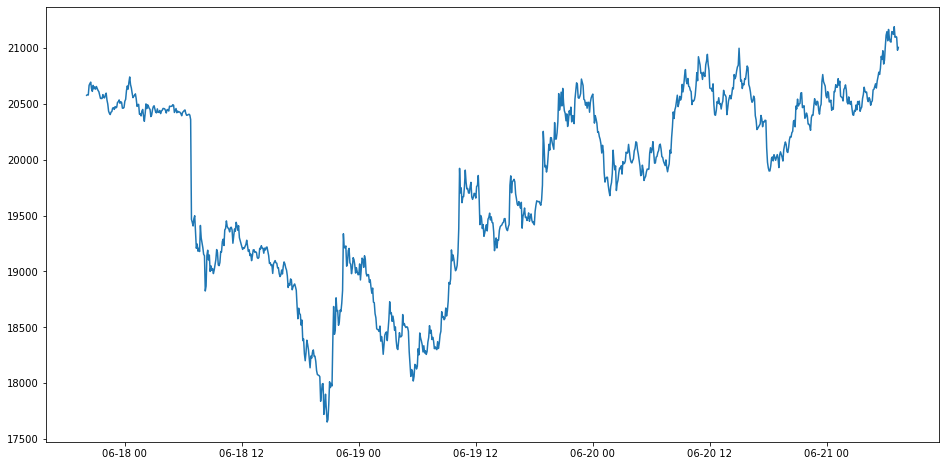

In [105]:
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')

In [106]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])

for i in range(0,len(data)):
  new_dataset["Date"][i]=data['Date'][i]
  new_dataset["Close"][i]=data["Close"][i]

scaler=MinMaxScaler(feature_range=(0,1))
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)
final_dataset=new_dataset.values


train_data=final_dataset[0:987,:]
valid_data=final_dataset[987:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
  x_train_data.append(scaled_data[i-60:i,0])
  y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

In [107]:
lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

927/927 - 16s - loss: 0.0063 - 16s/epoch - 17ms/step


In [108]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

1/1 [==============================] - 1s 896ms/step


In [109]:
lstm_model.save("lstm_model.h5")

C:\Users\lethanhviet\AppData\Local\Temp\ipykernel_13968\107833647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


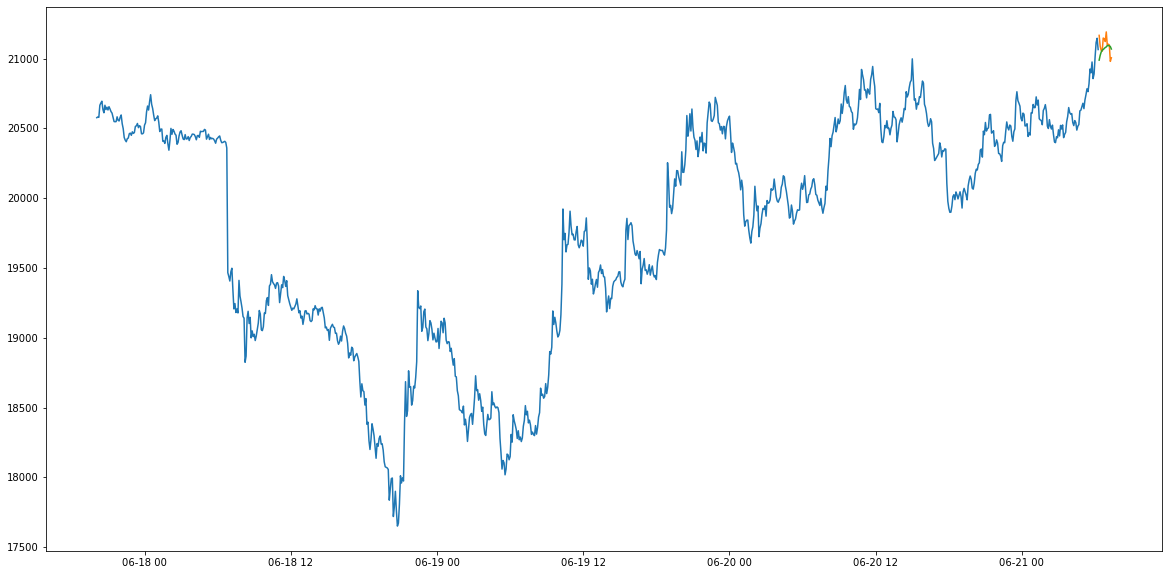

In [110]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])

In [111]:
rnn_model = Sequential()
rnn_model.add(LSTM(units = 45, return_sequences = True, input_shape = (x_train_data.shape[1], 1)))
rnn_model.add(Dropout(0.2))
for i in [True, True, False]:
  rnn_model.add(LSTM(units = 45, return_sequences = i))
  rnn_model.add(Dropout(0.2))

rnn_model.add(Dense(units = 1))
rnn_model.compile(optimizer = 'adam', loss = 'mean_squared_error')
rnn_model.fit(x_train_data, y_train_data, epochs = 10, batch_size = 32)

Epoch 1/10
29/29 [==============================] - 11s 74ms/step - loss: 0.0700
Epoch 2/10
29/29 [==============================] - 2s 85ms/step - loss: 0.0161
Epoch 3/10
29/29 [==============================] - 2s 73ms/step - loss: 0.0131
Epoch 4/10
29/29 [==============================] - 2s 83ms/step - loss: 0.0116
Epoch 5/10
29/29 [==============================] - 3s 87ms/step - loss: 0.0113
Epoch 6/10
29/29 [==============================] - 2s 73ms/step - loss: 0.0101
Epoch 7/10
29/29 [==============================] - 3s 99ms/step - loss: 0.0095
Epoch 8/10
29/29 [==============================] - 2s 74ms/step - loss: 0.0086
Epoch 9/10
29/29 [==============================] - 2s 71ms/step - loss: 0.0084
Epoch 10/10
29/29 [==============================] - 3s 100ms/step - loss: 0.0078


In [112]:
X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=rnn_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

1/1 [==============================] - 2s 2s/step


In [113]:
rnn_model.save("rnn_model.h5")

C:\Users\lethanhviet\AppData\Local\Temp\ipykernel_13968\107833647.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


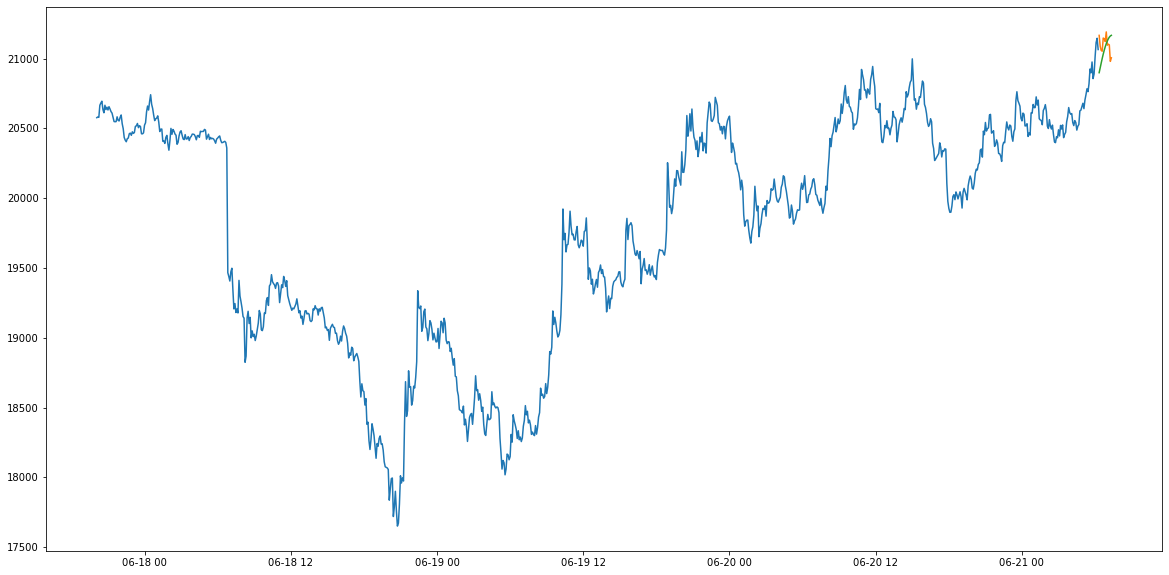

In [114]:
train_data=new_dataset[:987]
valid_data=new_dataset[987:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])